In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,\
                                    GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,\
                             RandomForestRegressor

In [19]:
df = pd.read_csv('../data/cleaned_merged_df.csv', index_col = 0)

In [20]:
income_cols = [col for col in df.columns if 'income' in col]
df.drop(columns=income_cols, inplace=True)

**Interpretation:** Income columns will leak data.

In [21]:
df.corr()['poverty_rate'].sort_values(ascending=True).head(20)

pct_white                                                     -0.431208
median_rent                                                   -0.425540
owner_occupied_housing_units_lower_value_quartile             -0.424752
owner_occupied_housing_units_median_value                     -0.403994
renter_occupied_housing_units_paying_cash_median_gross_rent   -0.391434
owner_occupied_housing_units_upper_value_quartile             -0.370109
median_age                                                    -0.233503
white_male_45_54                                              -0.176139
pct_asian                                                     -0.172310
white_male_55_64                                              -0.169933
white_pop                                                     -0.166289
pct_family_house                                              -0.161386
male_45_64_graduate_degree                                    -0.144641
male_45_64_bachelors_degree                                   -0

In [22]:
df.corr()['poverty_rate'].sort_values(ascending=False).head(20)

poverty_rate                                  1.000000
gini_index                                    0.591470
pct_black                                     0.480530
death_rate                                    0.277568
pct_amerindian                                0.226846
pct_nonfamily_house                           0.161386
staffed_icu_beds_[per_1000_elderly_(65+)]     0.115113
staffed_icu_beds_[per_1000_adults_(20+)]      0.111187
staffed_all_beds_[per_1000_elderly_(65+)]     0.109685
staffed_icu_beds_[per_1000_people]            0.107673
licensed_all_beds_[per_1000_elderly_(65+)]    0.103327
amerindian_pop                                0.100106
pct_female                                    0.094539
mobile_homes                                  0.074932
licensed_all_beds_[per_1000_adults_(20+)]     0.065482
licensed_all_beds_[per_1000_people]           0.057990
staffed_all_beds_[per_1000_adults_(20+)]      0.057538
pct_hispanic                                  0.053102
staffed_al

<AxesSubplot:ylabel='Frequency'>

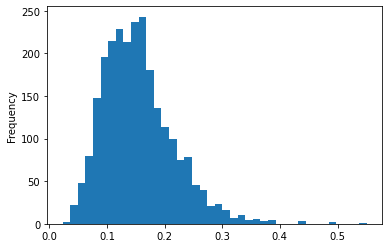

In [23]:
df['poverty_rate'].plot(kind='hist', bins=40)

Text(0, 0.5, 'DEATH RATE')

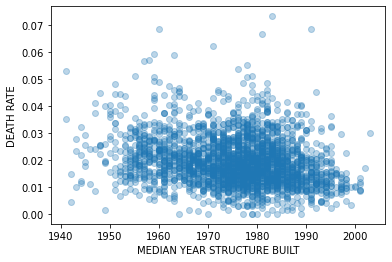

In [24]:
plt.scatter(df.loc[df['median_year_structure_built'] > 0].median_year_structure_built,
            df.loc[df['median_year_structure_built'] > 0].death_rate, alpha=.3)
plt.xlabel('MEDIAN YEAR STRUCTURE BUILT')
plt.ylabel('DEATH RATE')

In [25]:
X_cols = [col for col in df.columns if 'pct_' in col]
X_cols.remove('pct_not_hispanic')
X_cols.remove('pct_nonfamily_house')
X_cols.remove('pct_male')

X_cols.append('death_rate')
X_cols.append('median_year_structure_built')
X_cols.append('median_age')
X_cols.append('all_bed_occupancy_rate')

X = df[X_cols]
y = df['poverty_rate']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Linear Regression

In [27]:
lr = LinearRegression()
cv_score = cross_val_score(lr, X_train, y_train)
print(cv_score.mean(), cv_score.std())
cv_score

0.42196112435672833 0.01544343719214156


array([0.40833959, 0.4040624 , 0.42092418, 0.44705809, 0.42942137])

In [28]:
lr.fit(X_train_sc, y_train)
print('train score', lr.score(X_train_sc, y_train))
print('test score', lr.score(X_test_sc, y_test))

train score 0.4385247960206273
test score 0.44623238069364235


In [29]:
pd.DataFrame(lr.coef_, index=X_train.columns)[0].map(lambda x: round(x, 4)).sort_values()

pct_white                      -0.2412
pct_hispanic                   -0.1570
pct_black                      -0.1500
pct_amerindian                 -0.0687
pct_asian                      -0.0495
pct_two_or_more_races          -0.0218
pct_family_house               -0.0138
median_age                     -0.0115
all_bed_occupancy_rate         -0.0052
pct_other_race                 -0.0050
pct_male_male_households       -0.0033
pct_female_female_households   -0.0000
median_year_structure_built     0.0019
pct_female                      0.0030
death_rate                      0.0090
Name: 0, dtype: float64

Text(0, 0.5, 'POVERTY RATE')

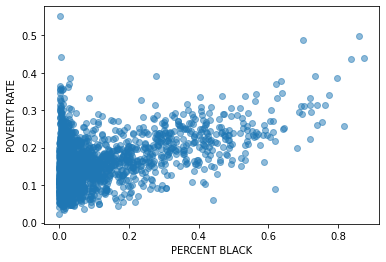

In [30]:
plt.scatter(df['pct_black'], df['poverty_rate'], alpha = .5)
plt.xlabel('PERCENT BLACK')
plt.ylabel('POVERTY RATE')

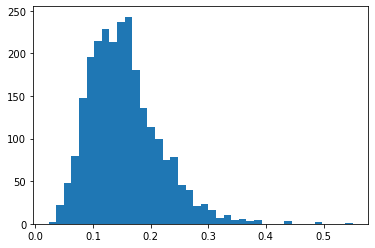

In [31]:
plt.hist(df['poverty_rate'], bins=40);

In [33]:
df.loc[df['poverty_rate'] > .4]

,date,county,state_name,confirmed_cases,deaths,death_rate,do_date,total_pop,households,male_pop,...,staffed_all_beds_[per_1000_people],staffed_all_beds_[per_1000_adults_(20+)],staffed_all_beds_[per_1000_elderly_(65+)],staffed_icu_beds_[per_1000_people],staffed_icu_beds_[per_1000_adults_(20+)],staffed_icu_beds_[per_1000_elderly_(65+)],licensed_all_beds_[per_1000_people],licensed_all_beds_[per_1000_adults_(20+)],licensed_all_beds_[per_1000_elderly_(65+)],icu_bed_source
22035,2021-06-03,East Carroll,Louisiana,1133,27.0,0.023831,2014-01-01,7225.0,2153.0,4373.0,...,3.268,4.466,22.137,0.0,0.0,0.0,3.268,4.466,22.137,Facility aggregation
28021,2021-06-03,Claiborne,Mississippi,1028,30.0,0.029183,2014-01-01,9120.0,3009.0,4312.0,...,2.444,3.384,14.946,0.0,0.0,0.0,3.555,4.922,21.739,Facility aggregation
28051,2021-06-03,Holmes,Mississippi,1900,74.0,0.038947,2014-01-01,18075.0,6269.0,8635.0,...,1.419,2.013,9.427,0.0,0.0,0.0,1.419,2.013,9.427,Facility aggregation
28063,2021-06-03,Jefferson,Mississippi,662,28.0,0.042296,2014-01-01,7346.0,2530.0,3642.0,...,1.689,2.245,10.008,0.0,0.0,0.0,4.222,5.613,25.021,Facility aggregation
46031,2021-06-03,Corson,South Dakota,481,12.0,0.024948,2014-01-01,4168.0,1186.0,2113.0,...,0.000,0.000,0.000,0.0,0.0,0.0,2.881,4.777,25.478,Facility aggregation
46121,2021-06-03,Todd,South Dakota,1234,32.0,0.025932,2014-01-01,10146.0,2703.0,4979.0,...,3.404,6.213,45.992,0.0,0.0,0.0,3.404,6.213,45.992,Facility aggregation


scaled  0.31177659, 0.34379026, 0.30268388, 0.30058899, 0.35387436]


In [40]:
lasso = Lasso(max_iter = 1000, alpha=.00001, tol = 0.0001)
cv_score = cross_val_score(lasso, X_train, y_train)
print(cv_score.mean(), cv_score.std())
cv_score

0.4158454905203969 0.01655951475889321


array([0.4112545 , 0.39156855, 0.40753016, 0.43412218, 0.43475206])

### Support Vector Regressor

In [41]:
# svr = SVR()

# params = {
#     'kernel': ['rbf', 'sigmoid', 'linear'],
#     'gamma': ['scale'],
#     'C': [.001, .01, .1, 1]
# }

# gs = GridSearchCV(svr, param_grid=params, verbose=3, n_jobs = 5)
# gs.fit(X_train_sc, y_train)
# print(gs.score(X_test, y_test))
# gs.best_params_

### Random Forest Regressor

In [42]:
rfr = RandomForestRegressor()

params = {
    'n_estimators': [75, 100, 125],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 10],
}

gs = GridSearchCV(rfr, param_grid=params, verbose=2, n_jobs = 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
train score 0.6816349774320616
test score 0.5465641186491467


{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 125}

In [43]:
rfr = RandomForestRegressor(max_depth=3,
 min_samples_leaf=10,
 min_samples_split=10,
 n_estimators=75)

print(cross_val_score(rfr, X_train, y_train))
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test), rfr.score(X_train, y_train))

[0.32951459 0.31421013 0.3080474  0.36071797 0.40235879]
0.35835818705144984 0.3847747476960297


<AxesSubplot:>

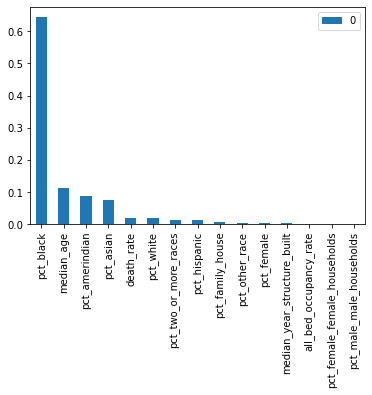

In [44]:
pd.DataFrame(rfr.feature_importances_, index=X_train.columns)\
.sort_values(by=0, ascending=False).plot(kind='bar')

### AdaBoost Regressor

In [45]:
ada = AdaBoostRegressor()

params = {
    'n_estimators': [40, 50, 70, 100],
    'learning_rate': [.01, .001],
    'loss': ['linear', 'square', 'exponential']
}

gs = GridSearchCV(ada, param_grid=params, verbose=3, n_jobs= 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
train score 0.37257535968733135
test score 0.3458338405501077


{'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 70}

In [46]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=3,
                                                             min_samples_leaf=10,
                                                             min_samples_split=10,
                                                             n_estimators=75),
                        learning_rate=.001)

ada.fit(X_train, y_train)
print('train score', ada.score(X_train, y_train))
print('test score', ada.score(X_test, y_test))

train score 0.38916089354305294
test score 0.3676912957495354


### Gradient Boosting Regressor

In [47]:
gbr = GradientBoostingRegressor()

params = {
    'loss': ['ls', 'lad', 'huber'],
    'learning_rate': [.001, .001],
    'n_estimators': [120, 200, 250],
    'max_depth': [2, 3, 4]
}

gs = GridSearchCV(gbr, param_grid=params, verbose=3, n_jobs= 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

In [ ]:
df['pct_black'].max(), df['poverty_rate'].max()

In [ ]:
plt.scatter(df['poverty_rate'], df['death_rate'])
plt.xlabel('POVERTY RATE')
plt.ylabel('DEATH RATE');